# A Cross Validation on Maqu2507 data

In [1]:
import pandas as pd
from utility import clean_proteomics
from IPython.display import display

from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.feature_selection import RFECV,RFE
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning

#Import Models
from sklearn.svm import SVR
from tpot import TPOTRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LassoLarsIC
from sklearn.neural_network import MLPRegressor

from tqdm import tqdm

#SKlearn Metrics
from sklearn.metrics import mean_squared_error

import numpy as np

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Magic Numbers
seed=1001
training_sizes = np.vectorize(int)(np.vectorize(round)(np.linspace(6,24,10)))
test_size = 8
num_splits = 200

#RMSE
metric = lambda x,y: np.sqrt(mean_squared_error(x,y))

In [3]:
#Load Ajinomoto Data
df = pd.read_csv('data/EDD_Ajinomoto_Data.csv',header=[0, 1], index_col=0, skipinitialspace=False)

#Proteomics Clean-Up
df.loc[df[('Metadata','Cycle')]>0,df.columns.get_level_values(0)=='Targeted Proteomics'] = df.loc[df[('Metadata','Cycle')]>0].apply(clean_proteomics,axis=1).values

In [4]:
#Extract Maqu2507 Protein & Production Data
Maqu2507_df = df.loc[df[('Metadata','Pathway')]==2]
mean_df = Maqu2507_df.groupby([('Metadata','Cycle'),('Metadata','Strain'),('Metadata','IPTG')]).mean()
display(mean_df)
X = mean_df[[('Targeted Proteomics','sp|P69451|LCFA_ECOLI'),('Targeted Proteomics','sp|Q41635|FATB_UMBCA'),('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV')]]
Y = mean_df[('GC-MS','dodecan-1-ol')]*1e3


Protocol Name                                                      EMOPEC  \
Measurement Type                                      sp|P27250|AHR_ECOLI   
(Metadata, Cycle) (Metadata, Strain) (Metadata, IPTG)                       
1.0               1                  0.1                              0.0   
                  2                  0.1                              0.0   
                  3                  0.1                              0.0   
                  4                  0.1                              0.0   
                  5                  0.1                              0.0   
                  6                  0.1                              0.0   
                  7                  0.1                              0.0   
                  8                  0.1                              0.0   
                  9                  0.1                              0.0   
                  10                 0.1                              0.0   
                  11                 0.1                              0.0   
                                     0.5                              0.0   
                  12                 0.1                              0.0   
2.0               1                  0.1                              0.0   
                                     0.5                              0.0   
                                     1.0                              0.0   
                  2                  0.1                              0.0   
                                     0.5                              0.0   
                                     1.0                              0.0   
                  3                  0.1                              0.0   
                                     0.5                              0.0   
                                     1.0                              0.0   
                  4                  0.1                              0.0   
                                     0.5                              0.0   
                                     1.0                              0.0   
                  5                  0.1                              0.0   
                  7                  0.1                              0.0   
                  8                  0.1                              0.0   
                  9                  0.1                              0.0   
                  10                 0.1                              0.0   
                  11                 0.1                              0.0   
                  14                 0.1                              0.0   

Protocol Name                                                               \
Measurement Type                                      sp|P69451|LCFA_ECOLI   
(Metadata, Cycle) (Metadata, Strain) (Metadata, IPTG)                        
1.0               1                  0.1                              14.8   
                  2                  0.1                              92.4   
                  3                  0.1                              87.6   
                  4                  0.1                              14.8   
                  5                  0.1                              92.4   
                  6                  0.1                              87.6   
                  7                  0.1                              14.8   
                  8                  0.1                              92.4   
                  9                  0.1                              87.6   
                  10                 0.1                              14.8   
                  11                 0.1                              92.4   
                                     0.5                              92.4   
                  12                 0.1                              87.6   
2.0               1                  0.1                

In [5]:
#Model Definitions
polynomial_regressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(), scoring='r2')),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=seed))])

        
neural_regressor = Pipeline([('Scaling', StandardScaler()),
                         #('FeatureSelection',RFECV(RandomForestClassifier())),
                         #('FeatureSelection',BernoulliRBM()),
                         ('NeuralNetwork', MLPRegressor(max_iter=10000,hidden_layer_sizes=(10,10,10),random_state=seed))])

rf_regressor = RandomForestRegressor(random_state=seed)
tpot_regressor = TPOTRegressor(generations=10, population_size=50, cv=5, verbosity=2,random_state=seed).fit(X,Y).fitted_pipeline_

Optimization Progress:  18%|█▊        | 100/550 [00:10<01:13,  6.09pipeline/s]

Generation 1 - Current best internal CV score: -54125.79158179986


Optimization Progress:  27%|██▋       | 150/550 [00:23<01:56,  3.44pipeline/s]

Generation 2 - Current best internal CV score: -50176.331433436906


Optimization Progress:  36%|███▋      | 200/550 [00:30<00:53,  6.50pipeline/s]

Generation 3 - Current best internal CV score: -45336.45209134453


Optimization Progress:  45%|████▌     | 250/550 [00:40<01:34,  3.19pipeline/s]

Generation 4 - Current best internal CV score: -44261.511284106076


Optimization Progress:  55%|█████▍    | 300/550 [00:51<01:14,  3.37pipeline/s]

Generation 5 - Current best internal CV score: -39000.02036453447


Optimization Progress:  64%|██████▎   | 350/550 [01:02<00:42,  4.68pipeline/s]

Generation 6 - Current best internal CV score: -39000.02036453447


Optimization Progress:  73%|███████▎  | 400/550 [01:11<00:41,  3.61pipeline/s]

Generation 7 - Current best internal CV score: -39000.02036453447


Optimization Progress:  82%|████████▏ | 450/550 [01:32<00:39,  2.55pipeline/s]

Generation 8 - Current best internal CV score: -39000.02036453447


Optimization Progress:  91%|█████████ | 500/550 [01:47<00:16,  3.12pipeline/s]

Generation 9 - Current best internal CV score: -39000.02036453447


Generation 10 - Current best internal CV score: -39000.02036453447

Best pipeline: KNeighborsRegressor(Normalizer(LassoLarsCV(RandomForestRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=2, min_samples_split=18, n_estimators=100), normalize=False), norm=l1), n_neighbors=5, p=1, weights=distance)


In [6]:
models = [rf_regressor,tpot_regressor,neural_regressor,polynomial_regressor]
model_names = ['Random Forrest Regressor','TPOT Regressor','Neural Regressor','Polynomial Regressor','Aggregate Regressor']

In [7]:
#Define Test Split Function
split_df = mean_df[[('Targeted Proteomics','sp|P69451|LCFA_ECOLI'),('Targeted Proteomics','sp|Q41635|FATB_UMBCA'),('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV'),('GC-MS','dodecan-1-ol')]]
      
def cv_split(num_splits,test_size,training_size):
    for _ in range(num_splits):
        sample_df = split_df.sample(test_size+training_size).sample(frac=1)
        X_df = sample_df[[('Targeted Proteomics','sp|P69451|LCFA_ECOLI'),('Targeted Proteomics','sp|Q41635|FATB_UMBCA'),('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV')]]
        Y_df = sample_df[('GC-MS','dodecan-1-ol')]*1e3
        X_train = X_df.iloc[0:training_size]
        X_test  = X_df.iloc[training_size:]
        Y_train = Y_df.iloc[0:training_size]
        Y_test  = Y_df.iloc[training_size:]
        yield X_train,X_test, Y_train, Y_test

        
def calculate_weights(x,alpha=0.01):
    """Apply softmax function to a list of numbers and return a list of probabilities."""
    y = -alpha*(x/max(x)*100)
    e_x = np.exp(y)
    return e_x / e_x.sum()

In [8]:
#Fit Models with Various Sizes of Cross Validation Sets
scores = np.zeros([len(models)+1,len(training_sizes),num_splits])

for j,training_size in enumerate(training_sizes):
    print(j,training_size)
    for k,(X_train,X_test,y_train,y_test) in tqdm(enumerate(cv_split(num_splits,test_size,training_size))):
        predictions = []
        agg_scores = []

        for i,model in enumerate(models):


            #Compute the Cross Val Score
            model = model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            predictions.append(y_pred)
            score = metric(y_test,y_pred)
            agg_scores.append(score)
            scores[i,j,k] = score
            #scores[i,j,k] = model.score(X_test, y_test,)
            
        #Compute predictions for aggregate model
        #Calculate Weights based on scores
        weights = calculate_weights(scores[0:4,j,k])
        
        #Compute new predictions
        y_pred = np.array([[w*p for p in prediction] for w,prediction in zip(weights,predictions)])
        y_pred = np.sum(y_pred,axis=0)
        
        #Calculate cross val score
        scores[-1,j,k] = metric(y_test,y_pred)

0it [00:00, ?it/s]

0 6


200it [05:25,  1.63s/it]
0it [00:00, ?it/s]

1 8


49it [01:44,  2.12s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
145it [04:59,  2.06s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [06:53,  2.07s/it]
0it [00:00, ?it/s]

2 10


73it [02:41,  2.21s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
152it [05:46,  2.28s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
162it [06:08,  2.27s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [07:39,  2.30s/it]
0it [00:00, ?it/s]

3 12


18it [00:50,  2.83s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
156it [06:45,  2.60s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
167it [07:15,  2.61s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
168it [07:19,  2.62s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

4 14


11it [00:27,  2.50s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
15it [00:39,  2.66s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
147it [06:50,  2.79s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [09:08,  2.74s/it]
0it [00:00, ?it/s]

5 16


21it [00:58,  2.77s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
54it [02:21,  2.62s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
61it [02:46,  2.73s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
121it [05:42,  2.83s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (

6 18


131it [05:31,  2.53s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
139it [05:57,  2.58s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
189it [08:09,  2.59s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [08:42,  2.61s/it]
0it [00:00, ?it/s]

7 20


147it [06:19,  2.58s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [08:39,  2.60s/it]
0it [00:00, ?it/s]

8 22


84it [03:50,  2.75s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
107it [04:42,  2.64s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
136it [05:58,  2.63s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
186it [08:10,  2.64s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations

9 24


140it [05:47,  2.48s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
200it [08:04,  2.42s/it]


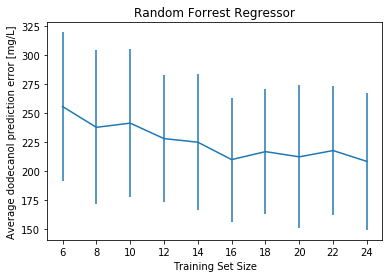

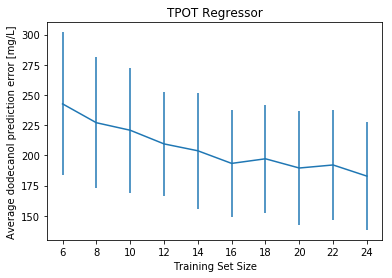

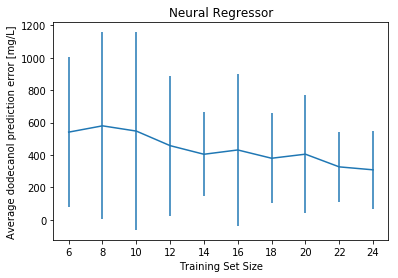

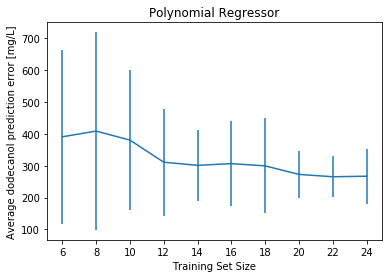

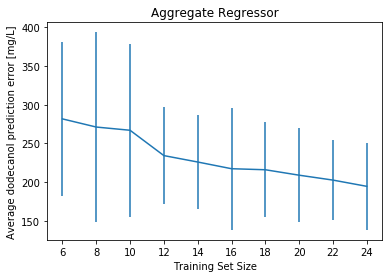

In [13]:
import matplotlib.pyplot as plt

#Plot Model Mean and Standard Deviation Based on Training Size
for i,model_name in enumerate(model_names):
    
    x = training_sizes
    
    #Compute Mean
    y = np.mean(scores[i,:,:],axis=1)
    
    #Compute Standard Deviation
    y_err = np.std(scores[i,:,:],axis=1)
    
    
    plt.errorbar(x, y, yerr=y_err)
    plt.title(model_name)
    plt.xlabel('Training Set Size')
    plt.ylabel('Average dodecanol prediction error [mg/L]')
    plt.xticks(x)
    plt.savefig('figures/{}_training_error_vs_size.pdf'.format(model_name))
    plt.show()
    #print(x,y,y_err)